In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import glob
import os
import subprocess
import warnings
import numpy as np
import matplotlib.pyplot as plt
import photutils
import pyregion


In [2]:
curpath = os.path.abspath('/home/aditi/ksp/data')                   # top level directory
dataFolder = os.path.join(curpath, 'g_band_data')        # data directory
biasFolder = os.path.join(dataFolder, 'bias')     # bias frames subdirectory
flatFolder = os.path.join(dataFolder, 'flat')     # flat fields subdirectory
sciFolder = os.path.join(dataFolder, 'data')   # science data subdirectory
procFolder = os.path.join(curpath, 'processing')  # processing directory
if not os.path.isdir(procFolder): 
    os.mkdir(procFolder)
else:
    for f in os.listdir(procFolder):
        try:
            os.remove(os.path.join(procFolder,f)) # clear the processing folder from previous iterations
        except:
            print('Could not remove',f)

In [3]:
os.chdir(sciFolder)
fileList = sorted(glob.glob('*.fits'))
os.chdir(curpath)
biasList = sorted(glob.glob(os.path.join(biasFolder,'*.fits')))
flatList = sorted(glob.glob(os.path.join(flatFolder,'*.fits')))
sciList = [os.path.join(sciFolder, file) for file in fileList]
procList = [os.path.join(procFolder, file).replace('.fits','.proc.fits') for file in fileList]
print('Found',len(biasList),'bias files; ',len(flatList),'flat files; ',len(sciList),'science files')

Found 14 bias files;  8 flat files;  30 science files


In [4]:

warnings.filterwarnings("ignore")

In [5]:
exampleFile = sciList[0]         # The first science image
HDUList = fits.open(exampleFile) # Open the file
HDUList.info()                   # Print some information about the FITS file structure.  
## Print some header properties

header = HDUList[0].header # Get the header out of the HDU list.
print(repr(header[0:13]))  # Print the first 14 lines of the header (in raw format).
print(repr(header[24:34])) # Print some additional lines
print(repr(header[48:52])) 
print(repr(header[67:71])) 
print(repr(header[129:135])) 
print()
print('The object is:', header['OBJECT'])   # Print the name of the object being observed
# print('The filters are:', header['ACAMFILT']) # Print the names of the optical filters in the light path.
print('The exposure time is:', header['EXPTIME'])  # Print the exposure time

Filename: /home/aditi/ksp/data/g_band_data/data/20230520151900-863-RA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     133   (4096, 4108)   int16 (rescales to uint16)   
SIMPLE  =                    T / conform to FITS standard                       
BITPIX  =                   16 / unsigned short data                            
NAXIS   =                    2 / number of axes                                 
NAXIS1  =                 4096 / length of data axis                            
NAXIS2  =                 4108 / length of data axis                            
EXTEND  =                    T / this is FITS with extensions                   
HISTORY Created with RTS2 version 0.9.5 build on May 12 2020 19:07:30.          
CTIME   =           1684595940 / exposure start (seconds since 1.1.1970)        
USEC    =               863089 / exposure start micro seconds                   
JD      =     2460085.13819481 / Modified Julia

In [6]:
# Function to find the corresponding flat frame for a given date
default_master_flat_path = os.path.join(flatFolder, 'masterflat_g_.fits')
# default_master_flat = CCDData.read(default_master_flat_path, unit='adu')

def find_flat_for_date(date):
    flat_filename = f'{date}_masterflat_g_.fits'
    flat_path = os.path.join(flatFolder, flat_filename)
    if os.path.exists(flat_path):
        return flat_path
    else:
        return default_master_flat_path

In [7]:
print(flatList)
import re

def extract_date_from_path(file_path):
    # Extract the file name from the path
    file_name = os.path.basename(file_path)
    
    # Define the regular expression pattern for the date
    date_pattern = r"\d{8}"
    
    # Search for the pattern in the file name
    match = re.search(date_pattern, file_name)
    
    if match:
        return match.group(0)
    else:
        return None

['/home/aditi/ksp/data/g_band_data/flat/20230524_masterflat_g_.fits', '/home/aditi/ksp/data/g_band_data/flat/20230525_masterflat_g_.fits', '/home/aditi/ksp/data/g_band_data/flat/20230526_masterflat_g_.fits', '/home/aditi/ksp/data/g_band_data/flat/20230527_masterflat_g_.fits', '/home/aditi/ksp/data/g_band_data/flat/20230603_masterflat_g_.fits', '/home/aditi/ksp/data/g_band_data/flat/20230605_masterflat_g_.fits', '/home/aditi/ksp/data/g_band_data/flat/20230606_masterflat_g_.fits', '/home/aditi/ksp/data/g_band_data/flat/masterflat_g_.fits']


In [8]:
## Bias subtract and flat-field all science frames and write out pre-processed files.

numSciFiles = len(sciList)
numBiasFiles = len(biasList)
numFlatFiles = len(flatList)
print('Found %d science files'%numSciFiles)

for i in range(numSciFiles):
    
    # Read in the FITS data.
    HDUList = fits.open(sciList[i])
    primaryHeader = HDUList[0].header
    imageData = HDUList[0].data    
    HDUList.close()
    date=extract_date_from_path(sciList[i])

    bias_image_path = os.path.join(biasFolder, f'{date}_masterbias.fits')
    flat_file_path=find_flat_for_date(date)

    # bias_image=[file for file in biasList if file.startswith(date)]
    # print(bias_image)
    HDUList = fits.open(bias_image_path)
    biasHeader = HDUList[0].header
    masterBias = HDUList[0].data
    HDUList.close()

    HDUList = fits.open(flat_file_path)
    flatHeader = HDUList[0].header
    masterFlatFixed = HDUList[0].data
    HDUList.close()

    # Correct for the bias and flats here
    procData = (imageData - masterBias) / masterFlatFixed

    # Prepare the output FITS structure in simple format
    procHDU = fits.PrimaryHDU(procData)  # Create a new HDU with the processed image data
    procHDU.header = primaryHeader       # Copy over the header from the raw file
    procHDU.header.add_history('Bias corrected and flat-fielded') # Add a note to the header

    # Write the reduced frame to disk
    print(sciList[i],'->',procList[i])
    procHDU.writeto(procList[i], overwrite=True)

Found 30 science files
/home/aditi/ksp/data/g_band_data/data/20230520151900-863-RA.fits -> /home/aditi/ksp/data/processing/20230520151900-863-RA.proc.fits
/home/aditi/ksp/data/g_band_data/data/20230521151417-752-RA.fits -> /home/aditi/ksp/data/processing/20230521151417-752-RA.proc.fits
/home/aditi/ksp/data/g_band_data/data/20230521154933-241-RA.fits -> /home/aditi/ksp/data/processing/20230521154933-241-RA.proc.fits
/home/aditi/ksp/data/g_band_data/data/20230522153045-729-RA.fits -> /home/aditi/ksp/data/processing/20230522153045-729-RA.proc.fits
/home/aditi/ksp/data/g_band_data/data/20230522154624-727-RA.fits -> /home/aditi/ksp/data/processing/20230522154624-727-RA.proc.fits
/home/aditi/ksp/data/g_band_data/data/20230523210842-911-RA.fits -> /home/aditi/ksp/data/processing/20230523210842-911-RA.proc.fits
/home/aditi/ksp/data/g_band_data/data/20230524180955-720-RA.fits -> /home/aditi/ksp/data/processing/20230524180955-720-RA.proc.fits
/home/aditi/ksp/data/g_band_data/data/20230524182725-

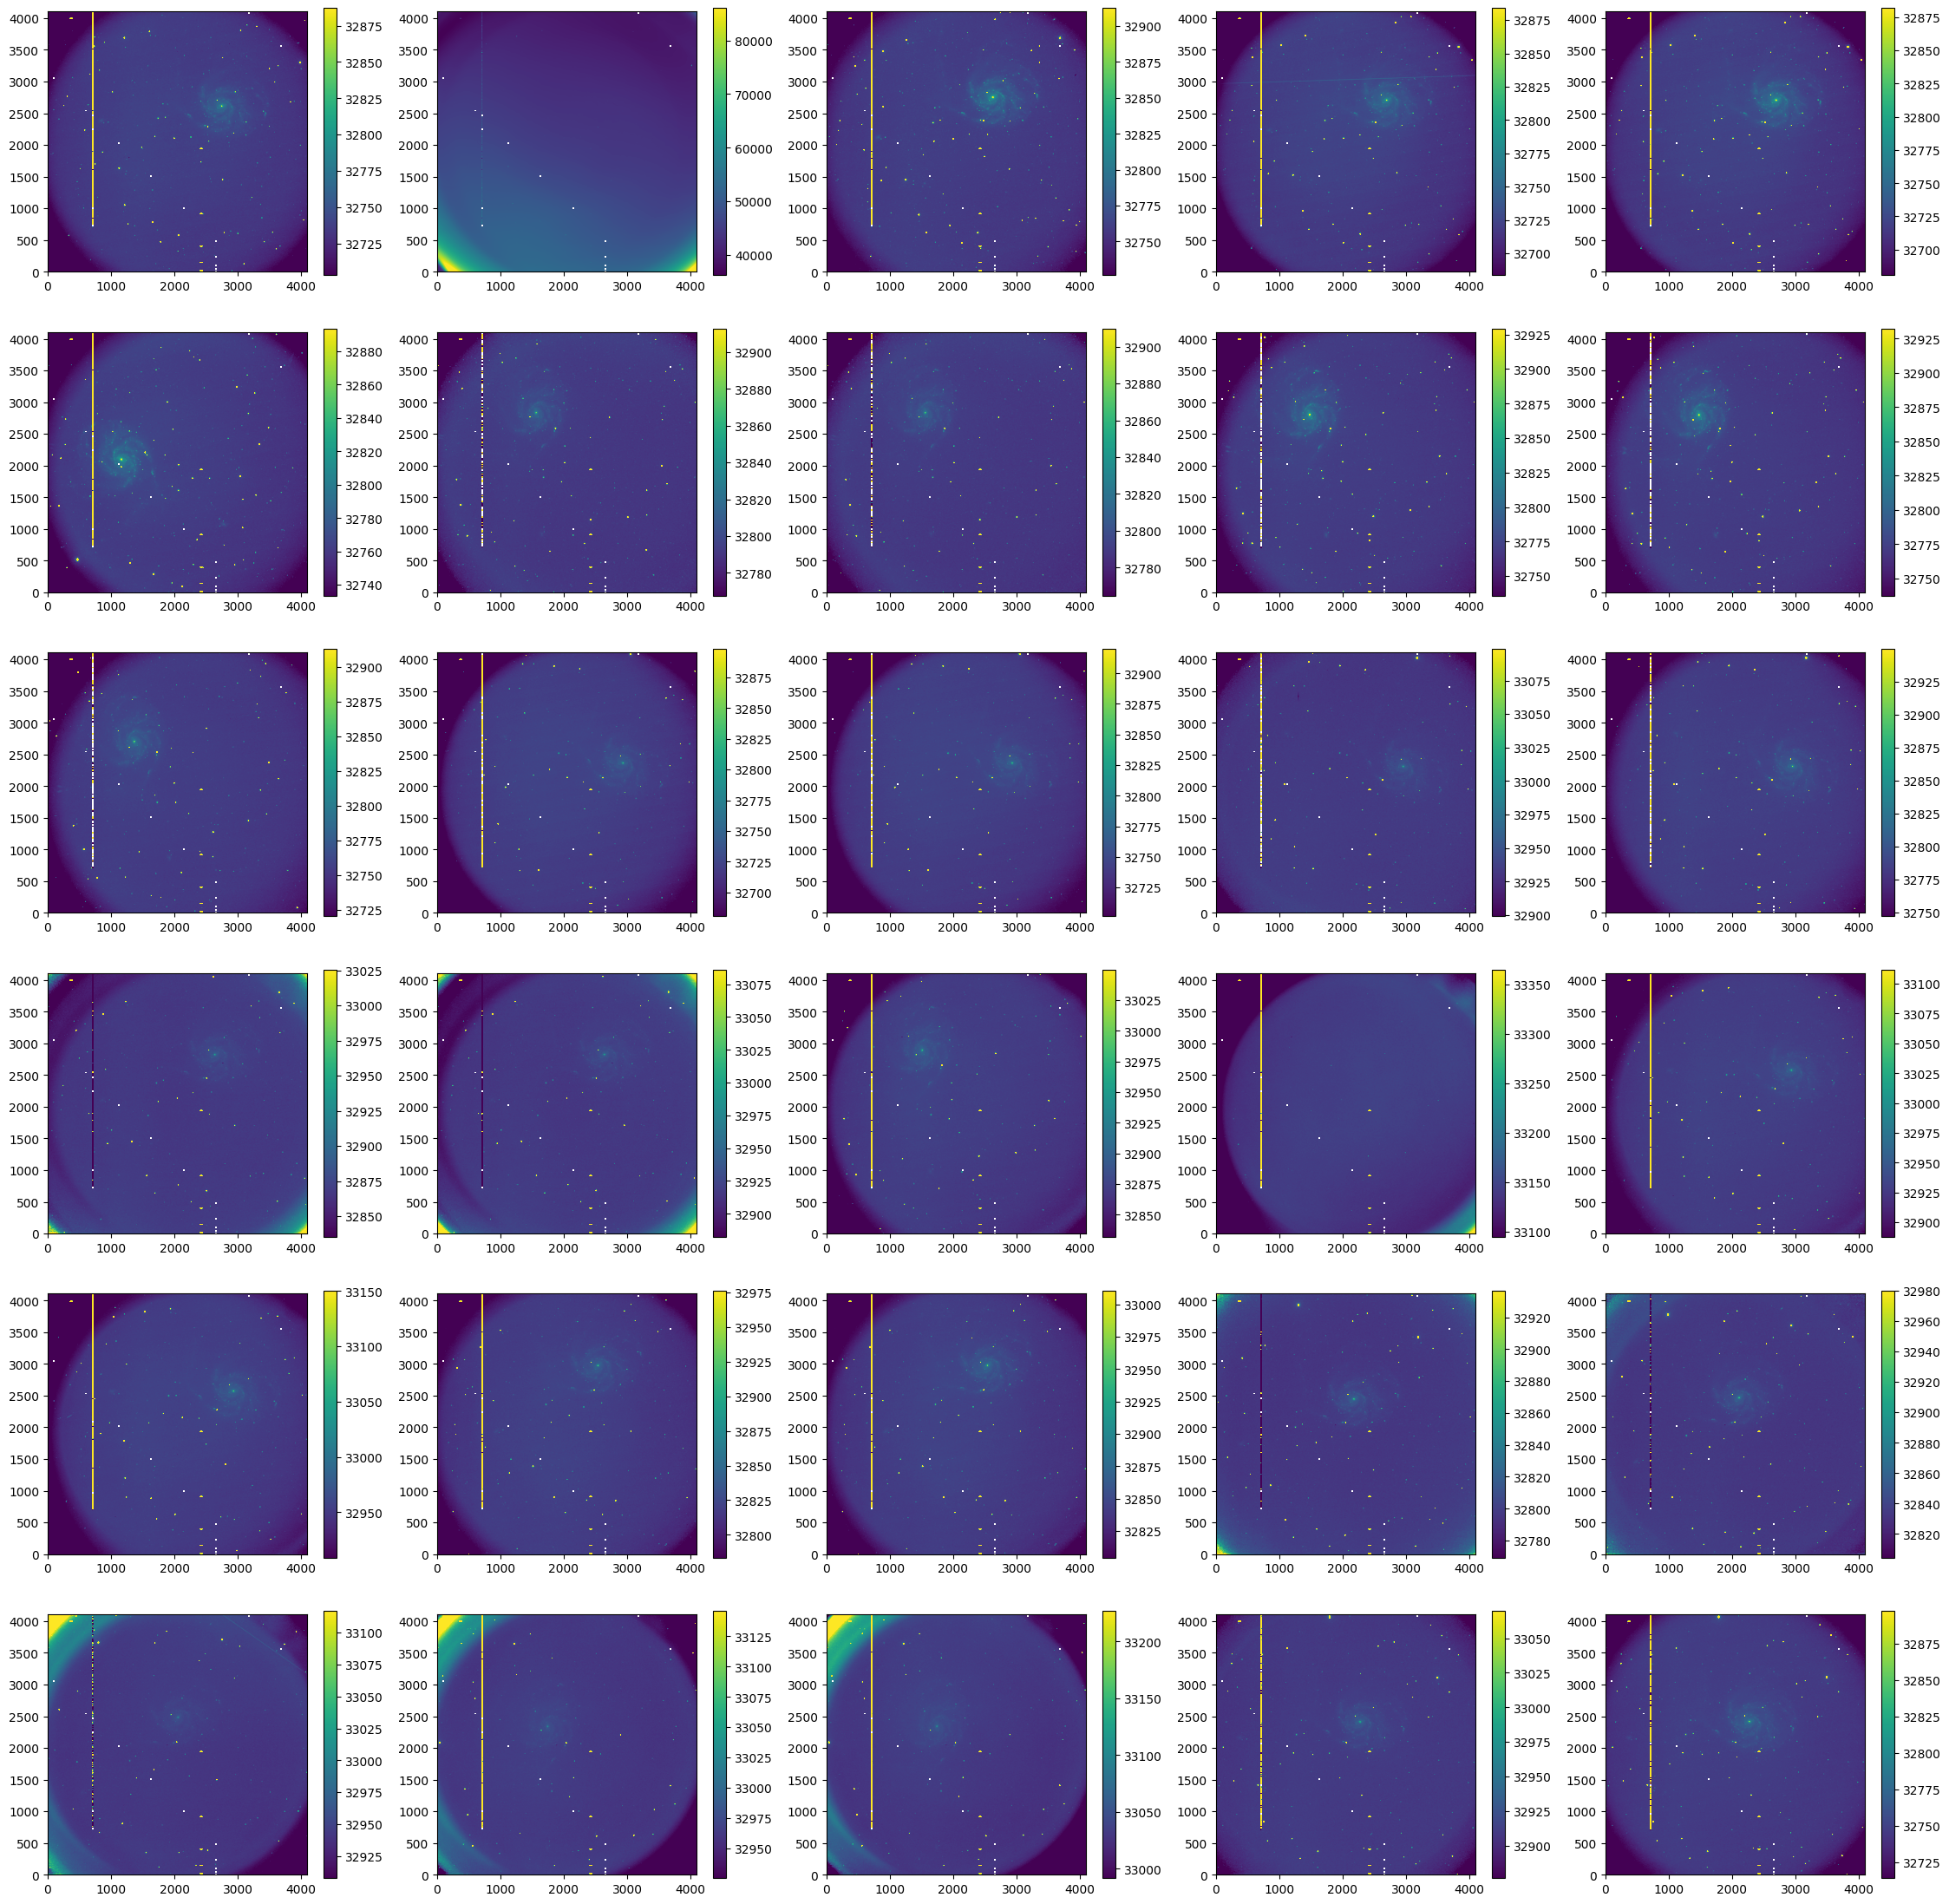

: 

In [9]:
numProcFiles = len(procList)
plt.figure(figsize=(28,28))
j = 1
for i in range(numProcFiles):
        if os.path.isfile(procList[i]):
            procHDU = fits.open(procList[i])
            procData = procHDU[0].data
            procHDU.close()
            
            mean, median, std = sigma_clipped_stats(procData)
            plt.subplot(6,5,j)
            j = j+1
            plt.imshow(procData, vmin = median - 2*std, vmax = median + 10*std, origin='lower')
            plt.colorbar()
        